In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1003.18it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 45.98it/s]

Using control points [0.        0.        0.7324547]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


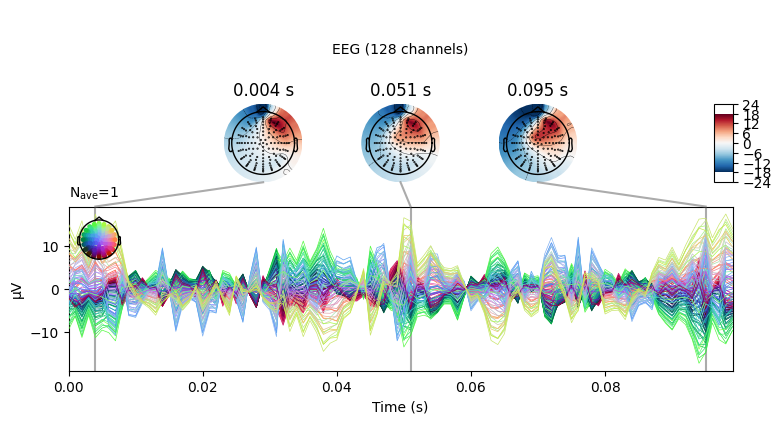

In [138]:
settings = dict(number_of_sources=3, extents=(1, 35), duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

Using control points [0.22843189 0.28902001 0.75740429]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


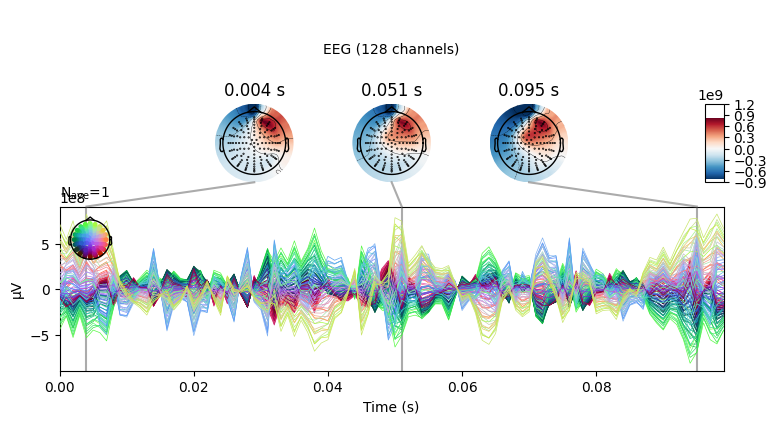

In [139]:
from invert import Solver
solver = Solver("SMAP")
solver.make_inverse_operator(fwd, evoked, alpha="auto")
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

0  Res var:  7199089.275517728
1  Res var:  7199089.275517728
2  Res var:  7199089.275517728
3  Res var:  7199089.275517728
4  Res var:  7199089.275517728
5  Res var:  7199089.275517728
6  Res var:  7199089.275517728
7  Res var:  7199089.275517728
8  Res var:  7199089.275517728
9  Res var:  7199089.275517728
10  Res var:  7199089.275517728
11  Res var:  7199089.275517728
12  Res var:  7199089.275517728
13  Res var:  7199089.275517728
14  Res var:  7199089.275517728
15  Res var:  7199089.275517728
16  Res var:  7199089.275517728
17  Res var:  7199089.275517728
18  Res var:  7199089.275517728
19  Res var:  7199089.275517728
20  Res var:  7199089.275517728
21  Res var:  7199089.275517728
22  Res var:  7199089.275517728
23  Res var:  7199089.275517728
24  Res var:  7199089.275517728
Using control points [0.00000000e+00 0.00000000e+00 1.60566967e-05]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarksty

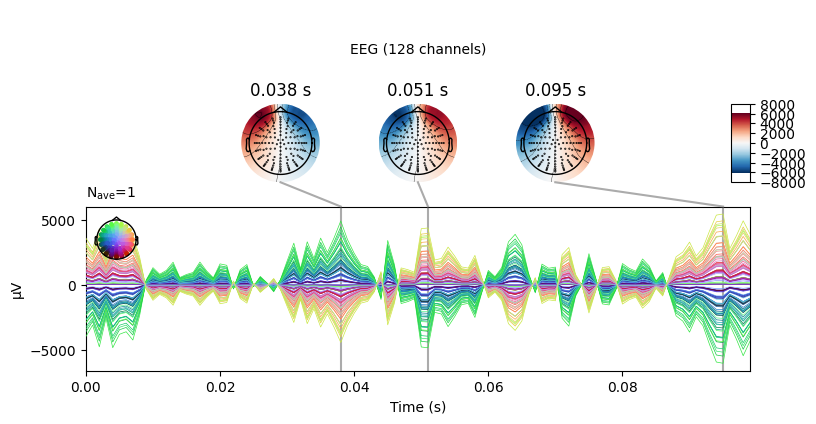

Using control points [0.00000000e+00 0.00000000e+00 1.74143302e-05]


In [141]:
from invert.adapters import stampc
stc_stamp = stampc(stc_, evoked, fwd, rv_thresh=1e-5)

brain = stc_stamp.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_stamp.data, info)
evoked_.plot_joint()

# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "SOMP", "SSMP", "SubSMP", "MNE", "dSPM", "LORETA", "eLORETA", "Bayesian Beamformer LORETA"]
settings = dict(number_of_sources=(1, 4), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)

# errors_corr = {sname: [] for sname in all_solvers}
# errors_mle = {sname: [] for sname in all_solvers}
# errors_auc = {sname: [] for sname in all_solvers}

# solvers = dict()

for i in range(20):
    print(i)
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    for solver_name in all_solvers:
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers):
            solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
        stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        error_corr = np.mean(corr(stc.data, stc_hat.data))
        try:
            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
        except:
            error_mle = np.nan
        error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        # print(error_corr, error_mle, error_auc)
    
    # print("Saving errors")
    # fn = "errors.pkl"
    # with open(fn, 'wb') as f:
    #     pkl.dump(errors, f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors = pkl.load(f)

# Plot

In [ ]:
df = pd.DataFrame(errors_mle)

plt.figure()
sns.distplot(df["eLORETA"])
sns.distplot(df["SubSMP"])

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)

df = pd.DataFrame(errors_corr)
# df = pd.DataFrame(errors_mle)
# df = pd.DataFrame(errors_auc)

sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

In [ ]:
# from invert.solvers.empirical_bayes import SolverChampagne
# from invert.solvers.esinet import SolverFullyConnected
# solver_fc = SolverFullyConnected().make_inverse_operator(fwd, evoked)
# solver_ch = SolverChampagne().make_inverse_operator(fwd, evoked)
from invert.evaluate import nmse, corr

stc_hat = solver_ch.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Champagne", 'title',
#                font_size=14)
error_ch = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

stc_hat = solver_fc.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Fully-Connected", 'title',
#                font_size=14)
error_fc = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

print(f"Champ: {error_ch}\nFC: {error_fc}")